Data analysis for the Franck-Hertz experiment

6 1 Rsq 0.9947512767477174
6 2 Rsq 0.9938221793858389
6 3 Rsq 0.9956549771388158
65 1 Rsq 0.9939159670436981


/tmp/ipykernel_5030/3201168453.py:102: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, covmat = sp.optimize.curve_fit(fit_dist, [2, 3], min_d)


65 2 Rsq 0.9901567778847399
65 3 Rsq 0.9912743007572278


/tmp/ipykernel_5030/3201168453.py:102: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, covmat = sp.optimize.curve_fit(fit_dist, [2, 3], min_d)


7 1 Rsq 0.9925995169167551
7 2 Rsq 0.9890935691120503
7 3 Rsq 0.9863270781751531
75 1 Rsq 0.989720562832314


/tmp/ipykernel_5030/3201168453.py:102: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, covmat = sp.optimize.curve_fit(fit_dist, [2, 3], min_d)


75 2 Rsq 0.981845774238883
75 3 Rsq 0.9780773458191998


/tmp/ipykernel_5030/3201168453.py:102: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, covmat = sp.optimize.curve_fit(fit_dist, [2, 3], min_d)


8 1 Rsq 0.9841737494166282
8 2 Rsq 0.9842017894717446
8 3 Rsq 0.9862860742390194
85 1 Rsq 0.9783967988164842


/tmp/ipykernel_5030/3201168453.py:102: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, covmat = sp.optimize.curve_fit(fit_dist, [2, 3], min_d)


85 2 Rsq 0.9824374888650912
85 3 Rsq 0.9914926425463352
9 1 Rsq 0.9732565423939811


/tmp/ipykernel_5030/3201168453.py:102: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, covmat = sp.optimize.curve_fit(fit_dist, [2, 3], min_d)


9 2 Rsq 0.9874891449519856
9 3 Rsq 0.9935997409849626
95 1 Rsq 0.9649654222299965


/tmp/ipykernel_5030/3201168453.py:102: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, covmat = sp.optimize.curve_fit(fit_dist, [2, 3], min_d)


95 2 Rsq 0.9890394784525094
95 3 Rsq 0.993946564106671
10 1 Rsq 0.9582053959595986


/tmp/ipykernel_5030/3201168453.py:102: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, covmat = sp.optimize.curve_fit(fit_dist, [2, 3], min_d)


10 2 Rsq 0.9920700674684547
10 3 Rsq 0.994369750595394


/tmp/ipykernel_5030/3201168453.py:102: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, covmat = sp.optimize.curve_fit(fit_dist, [2, 3], min_d)


[array([18.65326648,  0.15086207]),
 array([18.24120618,  0.19559229]),
 array([17.60804033,  0.26255708]),
 array([17.63819109,  0.27635328]),
 array([17.19598002,  0.33021625]),
 array([17.07537702,  0.35609182]),
 array([16.95477401,  0.37640782]),
 array([16.65326647,  0.41943271]),
 array([16.16080415,  0.47885572])]

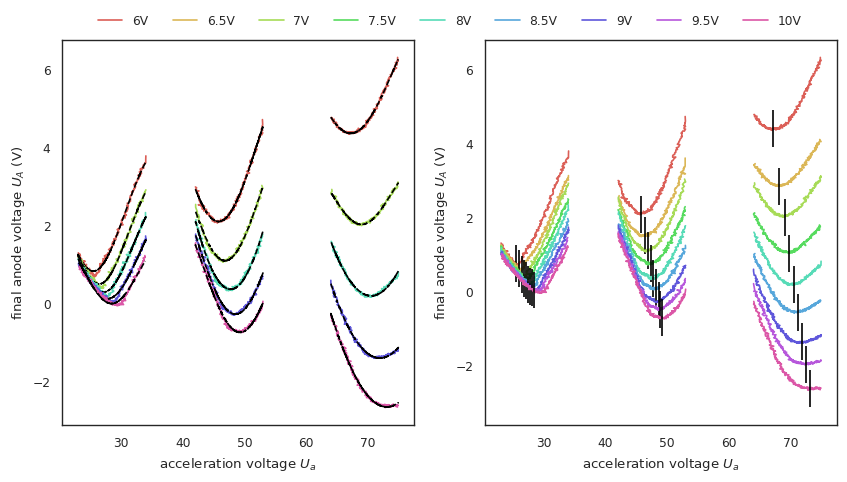

In [104]:
import numpy as np
import pandas as pd
import scipy as sp
import seaborn as sns
from uncertainties import *
import matplotlib.pyplot as plt


avgs = pd.DataFrame()
volts = [6, 65, 7, 75, 8, 85, 9, 95, 10]
plt.figure(figsize = (10,5))
E_lam_res = list()
sns.set_style("white")
sns.set_context("paper")

for m_i, m in enumerate(volts):

    # read all 5 iterations of the same measurement
    datas_1 = pd.DataFrame(); datas_2 = pd.DataFrame()
    for i in range(0, 5):
        # for channel 1
        data = pd.read_csv(str("data/scov" + str(m) + "_0" + str(i+1) + ".csv"), skiprows = [1])
        datas_1.insert(0, str(i), data["1"])
        datas_2.insert(0, str(i), data["2"])

    # compute mean and sd of the measurements
    res_1 = pd.concat([datas_1.mean(axis = 1), datas_1.std(axis = 1)], axis = 1)
    res_2 = pd.concat([datas_2.mean(axis = 1), datas_2.std(axis = 1)], axis = 1)
    res_m = res_1.join(res_2, lsuffix = "_2")
    res_m.columns = ["mean_1", "sd_1", "mean_2", "sd_2"]
    # create label with decimal point
    if "5" in str(m):
        m_lab = str(str(m)[0] + "." + str(m)[1] + "V")
    else:
        m_lab = str(str(m) + "V")
    res_m.insert(0, "finvolt", m_lab)
    res_m.insert(0, "time", data["x-axis"])
    # drop last voltage dropoff of data
    res_m = res_m.head(-115)
    
    # combine to one large df for plotting
    if avgs.empty:
        avgs = res_m
    else:
        avgs = pd.concat([avgs, res_m], axis = 0, ignore_index = True)

    # fit minima of channel 1 for three intervalls
    intervals = {"1": [23, 34], "2": [42, 53], "3": [64, 75]} # chosen visually from plot
    minima = np.zeros(3)
    for ind, i in enumerate(intervals.keys()):
        # only take data in interval as input
        input = res_m[(res_m["mean_2"] >= intervals[i][0]) & (res_m["mean_2"] <= intervals[i][1])]
        input = input.reset_index(drop = True) # reset row indices

        # fit minima of interval

        # gaussian minimum offset by grid voltage (not working as well)
        #def fit_fun(p, a, b, mu, sd): return(a*p**(3/2) -b*np.exp(-(p-mu)**2 / (2*sd**2)))
        #ubnd = abs(np.min(input["mean_1"]) / np.min(input["mean_2"]))
        #ps = [ubnd, 2, np.mean([input["mean_2"]]), np.mean([input["mean_2"]])/2]
        #bnds = ([0.7*ubnd,1,0,0], [1.3*ubnd,1000,1000,1000])

        # gaussian minimum with general offset
        def fit_fun(p, a, b, mu, sd): return(a -b*np.exp(-(p-mu)**2 / (2*sd**2)))
        ps = [0, 1, np.mean([input["mean_2"]]), np.mean([input["mean_2"]])/2]
        bnds = (0, 100)
        
        popt, covmat = sp.optimize.curve_fit(fit_fun, input["mean_2"], input["mean_1"], p0 = ps, bounds = bnds)
        y_est = fit_fun(input["mean_2"], popt[0], popt[1], popt[2], popt[3])

        residuals = input["mean_1"] - fit_fun(input["mean_2"], *popt)
        ss_res = np.sum(residuals**2)
        ss_tot = np.sum((input["mean_1"]-np.mean(input["mean_1"]))**2)
        r_squared = 1 - (ss_res / ss_tot)
        print(m, i, "Rsq", r_squared)

        if ind == 0 :
            dlab = m_lab
        else:
            dlab = None
        if (m_i % 2) == 0:
            # example plot for fit
            plt.subplot(121)
            plt.plot(input["mean_2"], input["mean_1"], color = sns.color_palette("hls", 9)[m_i], label = dlab)
            plt.plot(input["mean_2"], y_est, c ="black", ls = "--")

        # plot of fit estimates
        plt.subplot(122)
        plt.plot(input["mean_2"], input["mean_1"], color = sns.color_palette("hls", 9)[m_i], label = dlab)

        # find estimated minimum and add to array
        loc = np.where(y_est == np.min(y_est))[0]
        min_pos = input.iloc[loc[0]]["mean_2"]
        minima[ind] = min_pos
        plt.vlines(min_pos, input.iloc[loc[0]]["mean_1"]+0.5, input.iloc[loc[0]]["mean_1"]-0.5, color = "black")

    # compute distances between minima
    min_d = np.diff(minima)
    d_min_d = np.diff(min_d)[0]
    L = 5 # mm from manual
    def fit_dist(n, E, lam): return(E*(1 + (lam/L)*(2*n-1))) # E in e, lam in mm
    popt, covmat = sp.optimize.curve_fit(fit_dist, [2, 3], min_d)
    E_lam_res.append(popt)
# for minima plot
plt.subplot(121)
plt.xlabel("acceleration voltage $U_a$")
plt.ylabel("final anode voltage $U_A$ (V)")
plt.subplot(122)
plt.xlabel("acceleration voltage $U_a$")
plt.ylabel("final anode voltage $U_A$ (V)")
plt.legend(loc = 'center', bbox_to_anchor = (-0.1, 1.05), ncol = len(volts), frameon = False)
E_lam_res

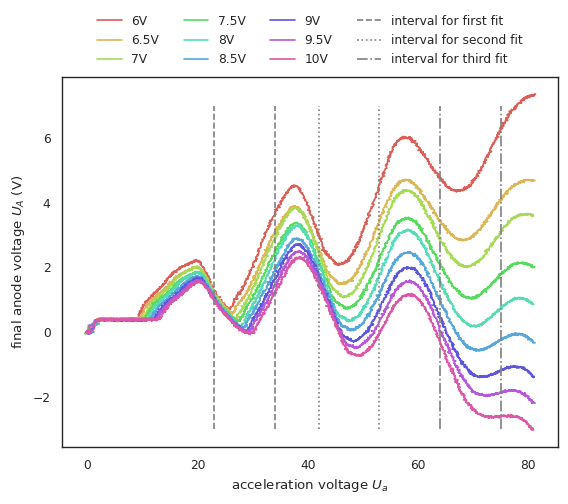

In [91]:
# plot all curves plus decided fit range in t
vals = avgs["finvolt"].unique()
for i in range(len(vals)):
    subset = avgs[avgs["finvolt"] == vals[i]]
    plt.plot(subset["mean_2"], subset["mean_1"], color = sns.color_palette("hls", 9)[i], label = vals[i])

plt.vlines(intervals["1"], -3, 7, color = "grey", ls = "--", label = "interval for first fit")
plt.vlines(intervals["2"], -3, 7, color = "grey", ls = ":", label = "interval for second fit")
plt.vlines(intervals["3"], -3, 7, color = "grey", ls = "-.", label = "interval for third fit")
plt.xlabel("acceleration voltage $U_a$")
plt.ylabel("final anode voltage $U_A$ (V)")
plt.legend(loc = 'center', bbox_to_anchor = (0.5, 1.1), ncol = 4, title = None, frameon = False)
plt.show()
